In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
import pickle
import nibabel as nib
from nibabel import Nifti1Image

from nilearn.datasets import fetch_atlas_destrieux_2009, fetch_atlas_surf_destrieux
from nilearn.plotting import view_img
from preprocessing.create_gray_matter_masks import get_gray_matter_mask_path

from nipype.algorithms.metrics import Similarity
from nipype.algorithms.misc import Gunzip
from preprocessing.make_spm_design_job_mat import get_sessions
from utils import SUBJECTS

sns.set_theme(font_scale=1.3)

Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/preprocessed/datasink/coregistered_source/sub-01/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10', 'ses-11']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/preprocessed/datasink/coregistered_source/sub-02/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/preprocessed/datasink/coregistered_source/sub-03/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/preprocessed/datasink/coregistered_source/sub-04/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/preprocesse

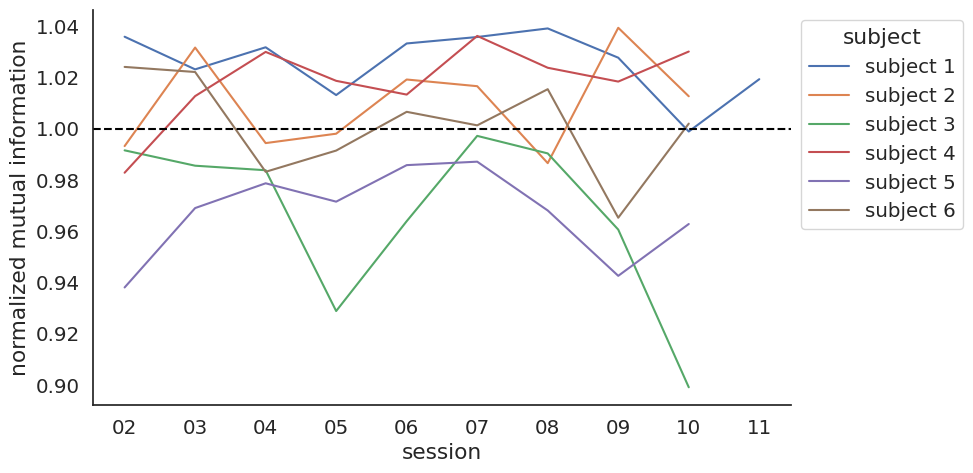

In [65]:
mi_data = []
for subject in SUBJECTS:
    sessions, session_dirs = get_sessions(f'/home/mitja/data/multimodal_decoding/fmri/preprocessed/datasink/coregistered_source/{subject}/')
    for session in sessions:
        t2_img_path = f'/home/mitja/data/multimodal_decoding/fmri/preprocessed/datasink/coregistered_source/{subject}/{session}/rmeana{subject}_{session}_task-coco_run-01_bold.nii'
        
        similarity = Similarity()
        similarity.inputs.volume1 = f'/home/mitja/data/multimodal_decoding/fmri/anat_downsampled/{subject}_ses-01_run-01_T1w_downsampled_2mm.nii'
        similarity.inputs.volume2 = t2_img_path#f'/home/mitja/data/multimodal_decoding/fmri/preprocessed/preprocess_workflow/_subject_id_{subject}/_session_id_{session}/coregister/rra{subject}_{session}_task-coco_run-01_bold_01.nii'
        # similarity.inputs.mask1 = get_gray_matter_mask_path(subject)
        # similarity.inputs.mask2 = get_gray_matter_mask_path(subject)
        similarity.inputs.metric = 'mi' # mutual information
    
        res = similarity.run()
        mi = res.outputs.similarity[0]
        # print(session, mi)
        subject_name = 'subject 6' if subject == 'sub-07' else subject.replace('sub-0', 'subject ') 
        mi_data.append({'subject': subject_name, 'session': session.split('-')[1], 'mutual_information': mi})

mi_data = pd.DataFrame(mi_data)

for subj in mi_data.subject.unique():
    data_subj = mi_data[mi_data.subject == subj]
    data_subj_ses01 = data_subj[data_subj.session == '01']
    ses1_value = data_subj_ses01['mutual_information'].values[0]
    print(subj, ses1_value)
    mi_data.loc[mi_data.subject == subj,'mutual_information'] = data_subj['mutual_information'] / ses1_value
    # print(mi_data)
# print(mi_data)
mi_data = mi_data[mi_data.session != '01']

with sns.axes_style("white"):
    plt.figure(figsize=(10,5))
    ax = sns.lineplot(data=mi_data, x='session', y='mutual_information', hue='subject')
    sns.despine()
    plt.ylabel('normalized mutual information')
    plt.axhline(y=1, linestyle='--', color='black')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig('intersession_alignment.png', dpi=300)


Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-01/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10', 'ses-11']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-02/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-03/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-04/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-05/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']
Scanning for sessions in /home/mitj

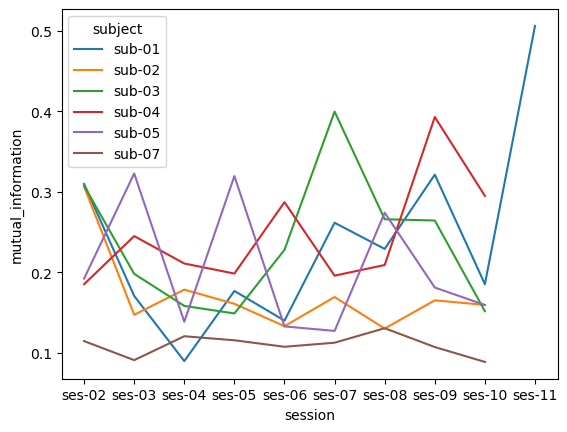

In [91]:
mi_data = []
for subject in SUBJECTS:
    sessions, session_dirs = get_sessions(f'/home/mitja/data/multimodal_decoding/fmri/bids/{subject}/')
    # print(subject, sessions)
    for session in sessions:
        if session == sessions[0]:
            continue

        unzip = Gunzip()
        unzip.inputs.in_file = f'/home/mitja/data/multimodal_decoding/fmri/bids/{subject}/{session}/anat/{subject}_{session}_run-01_T1w.nii.gz'
        res = unzip.run()
        unzipped_file_path = res.outputs.out_file
            
        similarity = Similarity()
        similarity.inputs.volume1 = f'/home/mitja/data/multimodal_decoding/fmri/bids/{subject}/ses-01/anat/{subject}_ses-01_run-01_T1w.nii'
        similarity.inputs.volume2 = unzipped_file_path
        # similarity.inputs.mask1 = get_gray_matter_mask_path(subject)
        # similarity.inputs.mask2 = get_gray_matter_mask_path(subject) #TODO with or without mask?
        similarity.inputs.metric = 'mi' # mutual information
        # similarity.inputs.metric = 'cc'
    
        res = similarity.run()
        mi = res.outputs.similarity[0]
        # print(session, mi)
        mi_data.append({'subject': subject, 'session': session, 'mutual_information': mi})

mi_data = pd.DataFrame(mi_data)
sns.lineplot(data=mi_data, x='session', y='mutual_information', hue='subject')
plt.savefig('mi_t1_t1.png', dpi=300)

Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-01/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10', 'ses-11']


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-02_run-01_T1w.nii
ses-02 1.0316218356254476


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-03_run-01_T1w.nii
ses-03 1.045540185476032


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-04_run-01_T1w.nii
ses-04 1.0406359112501073


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-05_run-01_T1w.nii
ses-05 1.0171106615080394


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-06_run-01_T1w.nii
ses-06 1.067905968373581


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-07_run-01_T1w.nii
ses-07 1.0313215605055917


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-08_run-01_T1w.nii
ses-08 1.0252696139970054


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-09_run-01_T1w.nii
ses-09 1.0246051377231737


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-10_run-01_T1w.nii
ses-10 1.0597707659925168


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-01_ses-11_run-01_T1w.nii
ses-11 0.9946093068974513
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-02/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-02_run-01_T1w.nii
ses-02 1.2023347569923843


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-03_run-01_T1w.nii
ses-03 1.291851437994596


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-04_run-01_T1w.nii
ses-04 1.258645942627216


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-05_run-01_T1w.nii
ses-05 1.2725299082058446


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-06_run-01_T1w.nii
ses-06 1.243884286055788


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-07_run-01_T1w.nii
ses-07 1.2360503014960387


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-08_run-01_T1w.nii
ses-08 1.2759695924075263


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-09_run-01_T1w.nii
ses-09 1.2436154040687555


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-02_ses-10_run-01_T1w.nii
ses-10 1.2732807496079892
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-03/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-02_run-01_T1w.nii
ses-02 1.017513486254215


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-03_run-01_T1w.nii
ses-03 1.046793409335433


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-04_run-01_T1w.nii
ses-04 1.047672590846133


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-05_run-01_T1w.nii
ses-05 1.0654233429633748


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-06_run-01_T1w.nii
ses-06 1.0566813753246904


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-07_run-01_T1w.nii
ses-07 1.05558904202509


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-08_run-01_T1w.nii
ses-08 1.0280219596843585


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-09_run-01_T1w.nii
ses-09 1.0501534305408857


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-03_ses-10_run-01_T1w.nii
ses-10 1.0977938802956813
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-04/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-02_run-01_T1w.nii
ses-02 1.0638413745315203


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-03_run-01_T1w.nii
ses-03 1.0765202962495781


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-04_run-01_T1w.nii
ses-04 1.0722074245755326


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-05_run-01_T1w.nii
ses-05 1.0701477138401418


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-06_run-01_T1w.nii
ses-06 1.069875951941417


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-07_run-01_T1w.nii
ses-07 1.0978329911671623


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-08_run-01_T1w.nii
ses-08 1.0482406258722266


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-09_run-01_T1w.nii
ses-09 1.0808792577169837


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-04_ses-10_run-01_T1w.nii
ses-10 1.073709320862349
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-05/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-02_run-01_T1w.nii
ses-02 1.1820194440860852


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-03_run-01_T1w.nii
ses-03 1.0307654163308337


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-04_run-01_T1w.nii
ses-04 1.1629467090600583


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-05_run-01_T1w.nii
ses-05 1.0887646791440921


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-06_run-01_T1w.nii
ses-06 1.1556779542023883


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-07_run-01_T1w.nii
ses-07 1.1702497297044467


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-08_run-01_T1w.nii
ses-08 1.010093095603389


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-09_run-01_T1w.nii
ses-09 1.0711723100680905


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-05_ses-10_run-01_T1w.nii
ses-10 1.135822780054024
Scanning for sessions in /home/mitja/data/multimodal_decoding/fmri/bids/sub-07/
Sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09', 'ses-10']


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-02_run-01_T1w.nii
ses-02 1.0514743872390078


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-03_run-01_T1w.nii
ses-03 1.0907373163569556


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-04_run-01_T1w.nii
ses-04 1.1134612310279446


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-05_run-01_T1w.nii
ses-05 1.0698298710603402


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-06_run-01_T1w.nii
ses-06 1.0689596870891052


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-07_run-01_T1w.nii
ses-07 1.1038062553725712


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-08_run-01_T1w.nii
ses-08 1.1183469528787815


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-09_run-01_T1w.nii
ses-09 1.1160804895557004


stty: 'standard input': Inappropriate ioctl for device


/home/mitja/multimodal_decoding/notebooks/rsub-07_ses-10_run-01_T1w.nii
ses-10 1.0660588724703621


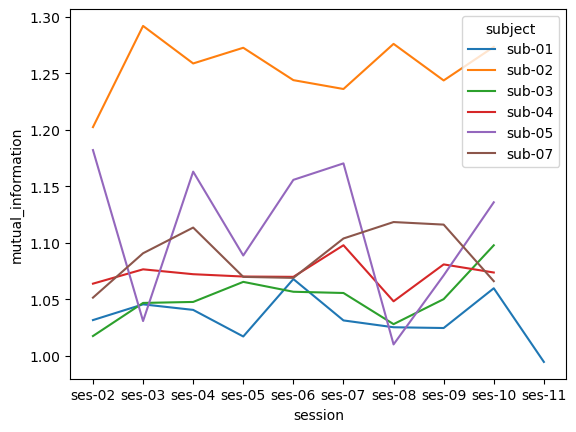

In [95]:
from nipype.interfaces.spm.preprocess import Coregister
mi_data = []
for subject in SUBJECTS:
    sessions, session_dirs = get_sessions(f'/home/mitja/data/multimodal_decoding/fmri/bids/{subject}/')
    # print(subject, sessions)
    for session in sessions:
        if session == sessions[0]:
            continue

        unzip = Gunzip()
        unzip.inputs.in_file = f'/home/mitja/data/multimodal_decoding/fmri/bids/{subject}/{session}/anat/{subject}_{session}_run-01_T1w.nii.gz'
        res = unzip.run()
        unzipped_file_path = res.outputs.out_file

        coreg = Coregister()
        coreg.inputs.target = f'/home/mitja/data/multimodal_decoding/fmri/bids/{subject}/ses-01/anat/{subject}_ses-01_run-01_T1w.nii'
        coreg.inputs.source = unzipped_file_path
        # print(coreg.help())
        res = coreg.run()
        coregistered_file_path = res.outputs.coregistered_source
        print(coregistered_file_path)
            
        similarity = Similarity()
        similarity.inputs.volume1 = f'/home/mitja/data/multimodal_decoding/fmri/bids/{subject}/ses-01/anat/{subject}_ses-01_run-01_T1w.nii'
        similarity.inputs.volume2 = coregistered_file_path
        # similarity.inputs.mask1 = get_gray_matter_mask_path(subject)
        # similarity.inputs.mask2 = get_gray_matter_mask_path(subject) #TODO with or without mask?
        similarity.inputs.metric = 'mi' # mutual information
        # similarity.inputs.metric = 'cc'
    
        res = similarity.run()
        mi = res.outputs.similarity[0]
        print(session, mi)
        mi_data.append({'subject': subject, 'session': session, 'mutual_information': mi})

mi_data = pd.DataFrame(mi_data)
sns.lineplot(data=mi_data, x='session', y='mutual_information', hue='subject')
plt.savefig('mi_t1_t1_coregistered.png', dpi=300)